# Evaluation on synthetic data

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib import pipeline
from lib import data_gen
import importlib
import matplotlib
importlib.reload(pipeline)
from mlreflect.models import DefaultTrainedModel, TrainedModel
from mlreflect.data_generation import ReflectivityGenerator
from mlreflect.training import InputPreprocessor, OutputPreprocessor
import tensorflow as tf
from tensorflow import keras
from mlreflect.curve_fitter import CurveFitter
from mlreflect.data_generation import interp_reflectivity
test_number_of_curves = 10240
#test_number_of_curves = 512

test_values_per_curve = 109
PARAMETERS = ["Film_thickness", "Film_roughness", "Film_sld"]
PARAMETERS_PLAIN = ["Thickness", "Roughness", "SLD"]


matplotlib.rcParams.update({
    "font.size": 20,
    "boxplot.boxprops.color": "gray",
    "boxplot.patchartist":True,
    "boxplot.showfliers": False,
    "boxplot.notch": True,
    "boxplot.medianprops.color": "firebrick",
    "patch.facecolor": "lightgray"
                         })

In [161]:
matplotlib.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [162]:
noise_level=0.1
BATCH_SIZE=256

In [163]:
# model_cnn = keras.models.load_model(
#     'models/current_state_models/0.001_0.2_100_100_50_12_8_512_20220705-194014')
# model_cnn=keras.models.load_model("models/current_state_models/0.0_800.0_25_50_100_10_8_6_512_20220714-124651")
model_cnn = keras.models.load_model(
    'models3l/0.1_25_50_75_12_8_4_256_20220719-091356')
mean_labels, std_labels = np.loadtxt(
    "data/mean_labels.csv"), np.loadtxt("data/std_labels.csv")
mean_data, std_data = np.loadtxt(
    f"data/mean_data_{noise_level}.csv"), np.loadtxt(f"data/std_data_{noise_level}.csv")

In [164]:
def predict_mlp_syn(gen_test, ip, out, data_test_true_real_scale):
    reflectivity_true_unit_scale = ip.standardize(data_test_true_real_scale)
    model = DefaultTrainedModel().keras_model
    pred_params_unit_scale = model.predict(reflectivity_true_unit_scale)
    pred_params_real_scale_full = out.restore_labels(pred_params_unit_scale)
    reflectivity_sim = gen_test.simulate_reflectivity(
        pred_params_real_scale_full)
    #print(model.summary())
    return reflectivity_sim, pred_params_real_scale_full

In [165]:
def predict_cnn_syn(generator, reflectivity_true_real_scale, labels):

    reflectivity_true_real_scale = reflectivity_true_real_scale.reshape(
        test_number_of_curves, test_values_per_curve, 1)
    pred_params_true_scale_full = labels.copy()
    
    labels=labels.drop(labels.columns.difference(["Film_thickness", "Film_roughness", "Film_sld"]), axis=1)
    labels=labels.to_numpy()
    dataset=tf.data.Dataset.from_tensor_slices((reflectivity_true_real_scale, labels)).batch(BATCH_SIZE)
    pred_params_unit_scale = model_cnn.predict(dataset)
    pred_params_true_scale = pred_params_unit_scale*std_labels+mean_labels
    
    pred_params_true_scale_full["Film_thickness"] = pred_params_true_scale[:, 0]
    pred_params_true_scale_full["Film_roughness"] = pred_params_true_scale[:, 1]
    pred_params_true_scale_full["Film_sld"] = pred_params_true_scale[:, 2]
    reflectivity_sim = generator.simulate_reflectivity(
        pred_params_true_scale_full)
    #print(model_cnn.summary())
    return reflectivity_sim, pred_params_true_scale_full

In [166]:
def get_mse(params_cnn, params_mlp, labels):
    mse=tf.keras.losses.MeanSquaredError()
    error_dict={}
    for idx, modelname in enumerate(["mlp", "cnn"]):
        
        cnn_parameters=params_cnn[PARAMETERS].to_numpy()
        mlp_parameters=params_mlp[PARAMETERS].to_numpy()
        #MSE errors
        model_params=[cnn_parameters, mlp_parameters]
        labels_parameters=labels[PARAMETERS].to_numpy()
        error_lst = []
        
        for entry_pred, entry_labels in zip(model_params[idx], labels_parameters):
            entry_pred=(entry_pred-mean_labels)/std_labels
            entry_labels=(entry_labels-mean_labels)/std_labels
            error_lst.append(mse(entry_pred, entry_labels).numpy())
        error_dict[modelname]=error_lst
    return error_dict

In [167]:
def make_analysis(reflectivity_true_real_scale, q_values, refl_sim_lst, params_cnn, params_mlp, labels, error_dict):
    
    fig_boxplot, axs_boxplot = plt.subplots(1)
    fig_boxplots_param_errors, axs_boxplots_param_errors = plt.subplots(
        2, 3, figsize=(15, 10))
    fig_curves, axs_curves = plt.subplots(2, 5, figsize=(15, 5), sharex=True)
    fig_curves.suptitle(
        "Ground truth vs. Predicted curves (simulations, no noise, pseudo test)")
    axs_boxplot.set_title("Comparison of MSE-Errors")
    

    #MSE errors boxplot
    axs_boxplot.boxplot(
        [error_dict["mlp"], error_dict["cnn"]], showfliers=False)
    axs_boxplot.set_xticklabels(["MLP", "CNN"])

    #Reflectivity Curves (ground truth)
    for idx, ax in enumerate(axs_curves.flat):
        ax.semilogy(
            q_values, reflectivity_true_real_scale[idx], label="ground truth", color="black")
        ax.legend()
    #Absolute errors
    for idx, (box, param) in enumerate(zip(axs_boxplots_param_errors[0,:], PARAMETERS)):
        box.boxplot([np.absolute(params_mlp[param]-labels[param]),
                    np.absolute(params_cnn[param]-labels[param])])
        if idx==0:
            box.set_title("Film Thickness")
        if idx==1:
            box.set_title("Film Roughness")
        if idx==2:
            box.set_title("Film SLD")    
        
        if idx is not 2:
            box.set_ylabel("Absolute error in $\mathrm{\AA}$")
        else:
            box.set_ylabel("Absolute error in $\mathrm{10^{-6} \AA^{-2}}$")
        box.set_xticklabels(["MLP", "CNN"])
        
    #Relative errors
    for idx, (box, param) in enumerate(zip(axs_boxplots_param_errors[1,:], PARAMETERS)):
        box.boxplot([100*np.absolute(params_mlp[param]-labels[param])/labels[param], 100 *
                    np.absolute(params_cnn[param]-labels[param])/labels[param]])
        
        box.set_xticklabels(["MLP", "CNN"])
        box.set_ylabel("Relative error in %")
    fig_boxplots_param_errors.tight_layout()

    fig_boxplot.tight_layout()

    fig_boxplots_param_errors.savefig("../fig/synth_perf/param_errors_synth_comp.pdf", dpi=fig_boxplots_param_errors.dpi)
    fig_boxplot.savefig("../fig/synth_perf/mse_error_synth_comp.pdf", dpi=fig_boxplots_param_errors.dpi)


In [168]:
def visualize_comparison():
    q_values = DefaultTrainedModel().q_values
    sample = DefaultTrainedModel().sample
    generator = ReflectivityGenerator(q_values, sample)
    labels = generator.generate_random_labels(test_number_of_curves)
    ip = InputPreprocessor()
    out = OutputPreprocessor(sample)
    reflectivity_true_real_scale = generator.simulate_reflectivity(labels)
    refl_sim_lst = []
    reflectivity_sim_mlp, params_mlp = predict_mlp_syn(
        generator, ip, out, reflectivity_true_real_scale)
    refl_sim_lst.append(reflectivity_sim_mlp)
    reflectivity_sim_cnn, params_cnn = predict_cnn_syn(
        generator, reflectivity_true_real_scale, labels)
    refl_sim_lst.append(reflectivity_sim_cnn)
    return reflectivity_true_real_scale, q_values, refl_sim_lst, params_cnn, params_mlp, labels

__Simulation__

In [169]:
reflectivity_true_real_scale, q_values, refl_sim_lst, params_cnn, params_mlp, labels=visualize_comparison()

100%|██████████| 10240/10240 [00:01<00:00, 5660.31it/s]


__Calculate MSE__

In [170]:
error_dict=get_mse(params_cnn, params_mlp, labels)

__Analysis plots__

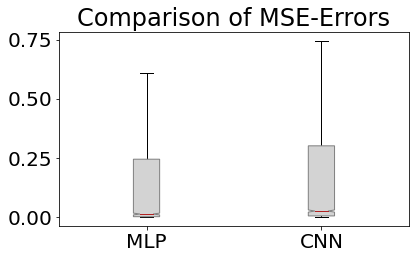

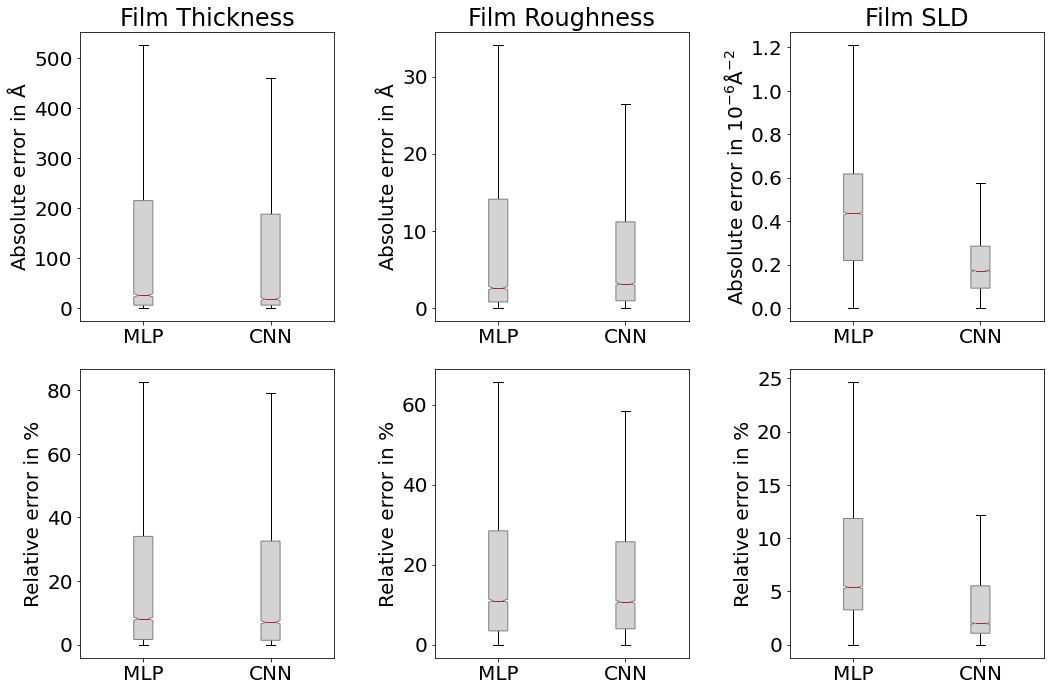

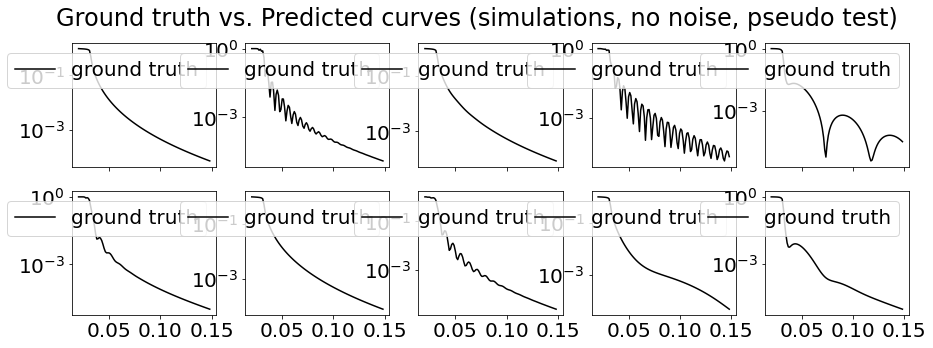

In [171]:
make_analysis(reflectivity_true_real_scale, q_values, refl_sim_lst, params_cnn, params_mlp, labels, error_dict)

In [172]:
plt.close('all')